# Data challenge
### Thomas J. Duignan

#### We will be looking at the raw data sets from the:

## National Survey on Drug Use and Health 

#### which is hosted at:

##### https://www.datafiles.samhsa.gov/study-series/national-survey-drug-use-and-health-nsduh-nid13517

#### Between the years 2011-2016

To reproduce this notebook, you must download the data sets yourself 
and define your own <b>paths</b> dictionary of {year: path} pointing to the tsv files

In [1]:
# Requirements: numexpr, pandas, seaborn
from preamble import * # Easier for git to manage source code
%matplotlib inline

In [2]:
# Reads all the tsvs according to the file structure defined by ``paths''
data = {key: pd.read_csv(path, sep='\t',
                         dtype={'FILEDATE': 'category',
                                 'GQTYPE2': 'category'}) 
        for key, path in paths.items()}

### Initial size of data set

In [3]:
afmt = ('{:>5}: {:<4} Rows: {:>6}, Columns: {:>4},'
        ' Memory: {:>4.0f}MB'.format)
ncol, nrow, size = 0, 0, 0
for key, df in data.items():
    nrow += df.shape[0]
    ncol = max(df.shape[1], ncol)
    mem = df.memory_usage().sum()
    size += mem
    print(afmt('Year', key, *df.shape, mem / (1024 ** 2)))
print(afmt('Total', '', nrow, ncol, size / (1024 ** 2)))

 Year: 2011 Rows:  58397, Columns: 3121, Memory: 1390MB
 Year: 2012 Rows:  55268, Columns: 3120, Memory: 1315MB
 Year: 2013 Rows:  55160, Columns: 3141, Memory: 1321MB
 Year: 2014 Rows:  55271, Columns: 3148, Memory: 1327MB
 Year: 2015 Rows:  57146, Columns: 2666, Memory: 1162MB
 Year: 2016 Rows:  56897, Columns: 2664, Memory: 1156MB
Total:      Rows: 338139, Columns: 3148, Memory: 7671MB


### Meta-analysis 
From the codebook pdfs associated with the data sets, values > 99 are minimal and uncertain and columns aren't identical between years.  To get a grapple on this, let's look at some summary data.

In [ ]:
srss = []
for key, df in data.items():
    srss.append(df.describe())
    srss[-1]['year'] = key

In [ ]:
year = 2011
for srs in srss:
    srs['year'] = year
    year += 1

In [ ]:
same = set(srss[0].columns.values)
for srs in srss[1:]: 
    for col in srs.columns: 
        same.add(col)

In [ ]:
sumdf = pd.concat(srss).reset_index().set_index(['year', 'index'])
# More to come here

### Columns of interest in this data set

We would like, at a minimum, to have some summary demographic information and as a first pass, we'll focus on age of first use and recent use of various drug categories surveyed in the data set.

### Clean-up and standardization of data set

#### Some survey questions and column names changed between the years

The codebooks (pdfs) provided with the data sets were used to standardize the column names for the purposes of this study. E.G.

In [5]:
print('Demographics  ', demographic[:5])
print('Before 2015   ', pre2015fixes[:5])
print('After 2014    ', pos2015fixes[:5])
# Conceptually identical columns with different suffixes
print('Naming quirks ', post)
# Column entries after 2014 are mapped to older column names. E.G.
print('Consistency   ', mapr)

Demographics   ['INCOME', 'ANYHLTI2', 'AGE2', 'SERVICE', 'HEALTH']
Before 2015    ['ALC', 'MJ', 'CIG', 'CIGAR', 'SNUF']
After 2014     ['ALC', 'MJ', 'CIG', 'CIGAR', 'SMKLSS']
Naming quirks  defaultdict(<function <lambda> at 0x7f4a0cb1a400>, {'MJ': 'AGE', 'ANAL': 'AGE', 'PNRNM': 'AGE', 'INH': 'AGE', 'INHAL': 'AGE', 'HALL': 'AGE', 'HALLUC': 'AGE', 'METH': 'AGE', 'METHAM': 'AGE'})
Consistency    {'PNRNMAGE': 'ANALAGE', 'PNRNMREC': 'ANALREC', 'INHALAGE': 'INHAGE', 'INHALREC': 'INHREC', 'HALLUCAGE': 'HALLAGE', 'HALLUCREC': 'HALLREC', 'METHAMAGE': 'METHAGE', 'METHAMREC': 'METHREC'}


#### Sanity check that all columns of interest are present and accounted for

In [6]:
# Meta-processing: check that appropriate columns
# are in each of the dataframes for each year
for key, df in data.items():
    print(key, end=' ')
    fixes = pre2015fixes if key < 2015 else pos2015fixes
    print(all([(fix + post[fix] in df.columns) for fix in fixes]), end=' ')
    print(all([(fix.replace('SNUF', 'SNF') + 'REC' in df.columns) 
               for fix in fixes]))

2011 True True
2012 True True
2013 True True
2014 True True
2015 True True
2016 True True


#### Now for the data reduction

In [7]:
dfs = []
for key, df in data.items():
    fixes = pre2015fixes if key < 2015 else pos2015fixes
    query = '|'.join([' ({} < 900) '.format(fix + post[fix]) 
                      for fix in fixes])
    cols = demographic + [fix + post[fix] for fix in fixes] + \
           [fix.replace('SNUF', 'SNF') + 'REC' for fix in fixes]
    sub = df.query(query, engine='numexpr')[cols]
    dfs.append(sub.rename(columns=mapr))
    dfs[-1]['year'] = key
df = pd.concat(dfs)

#### On to find something interesting

We will focus on the following:

In [8]:
print('Independent variables       ', independents)
print('Dependent variables         ', dependents)
print('Filters of meaningful data  ', filters)

Independent variables        ['ALC', 'CIG', 'MJ']
Dependent variables          ['HALL', 'METH', 'ANAL']
Filters of meaningful data   ['81', '4']


In [9]:
pivots = []
for fix in independents:
    for dep in dependents:
        indep = fix
        depen = dep + 'REC'
        inds = [indep + post[indep], indep + 'REC']
        # Generate a query string to slice the dataframe
        query = ' & '.join(['({} < {})'.format(ind, fil) 
                            for ind, fil in zip(inds, filters)])
        # Aggregate the data as a function of two independent variables
        # and sum over the dependent variable such that participants
        # reported use within the last 12 months
        srs = df.query(query).groupby(inds).apply(lambda x: 
                                                  x[depen][x[depen] < 3].sum())
        # Pivot the sub-set to a matrix with age of first use
        # along the X axis and recent use of independent variable
        # along the Y axis
        pivots.append(srs.reset_index().pivot(*inds, 0).fillna(0.))
# Compute the largest value obtained in this way
# to normalize the color map in the subsequent plot
norm = max([i.max().max() for i in pivots])

In [10]:
def plot1():
    fig, axes = sns.mpl.pyplot.subplots(3, 3, 
                                        sharex=True, 
                                        sharey=True,
                                        figsize=(10, 10))
    fig.subplots_adjust(**{'wspace': 0, 'hspace': 0})
    for i, arr in enumerate(axes):
        ind = independents[i]
        for j, ax in enumerate(arr):
            dep = dependents[j]
            ax.imshow(pivots[i*3 + j].loc[:42],#)
                      vmin=0, vmax=norm)
            ax.set_xlim([0, 2])
            if not i: ax.set_title(plabels[dependents[j]])
            if not j: ax.set_ylabel(plabels[independents[i]])
            if j == 2: 
                ax.set_xticks([0, 1, 2])
                ax.set_xticklabels(xlabs)
            ax.text(0, 40, 'Max: {}'.format(int(pivots[i*3 + j].loc[:42].max().max())),
                    color='white')
            square_ax(ax)
    fig.suptitle('Recent Hard Drug Use Based on Age of '
                 'First Common Drug Use and Recent Common Drug Use', y=1.02)
    fig.tight_layout()
    return fig

def plot2():
    fig, axes = sns.mpl.pyplot.subplots(nrows=1, ncols=3, sharey=True,
                                        figsize=(10, 6))
    axes[0].set_ylabel('Used Pain Killers in Last Year')
    for ax, piv in zip(axes, [pivots[-7], pivots[-4], pivots[-1]]):
        tmp = piv.rename(columns={j + 1: xlab
                                  for j, xlab in enumerate(xlabs)})
        tmp.index.rename('Age First Tried ' + plabels[piv.index.name], 
                         inplace=True)
        tmp.loc[:40].plot(ax=ax)
        ax.set_title('Recent Use of ' + plabels[piv.index.name])
        ax.set_xlim([0, 40])
    fig.suptitle('Use of Pain Killers Compared With Recent Use Of Common Drugs')
    return fig

#### Analysis of the following plot
<b>Y axis:</b> represents the age at which a participant first used a so-called "common drug". It is clear looking at the first panel that teens experiment with alcohol, cigarettes and marijuana.  This is unsurprising.

<b>X axis:</b> represents how recently a participant used a common drug. Participants were asked to determine if they used the drug within the last 30 days, between 30 days and 12 months ago, or more than 12 months ago.

<b>Color map:</b> denotes the number of instances that a participant used a so-called "hard drug" within the last year, given the age they started a common drug and how recently they used that common drug.

<b>Max:</b> is the largest value in the subplot.

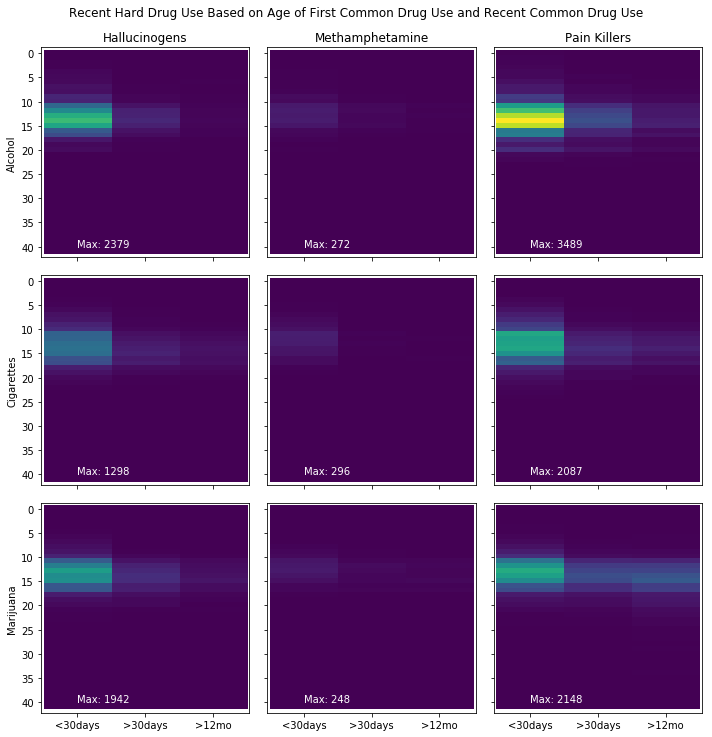

In [11]:
fig = plot1()

In [12]:
fig.savefig('fig1.pdf')

#### Results
Though it may look like habitual methamphetamine use is less of an issue according to the maxima, the data set aggregates hallucinogens and pain killers as classes of compounds, whereas for methamphetamine, the questions are specific to the drug itself, not the class of compounds.

It is often hypothesized that marijuana is a gateway drug that leads to hard drug use because of habituation.  This hypothesis is both supported and contradicted in numerous studies.  The most apparent feature about the figure above is a "tail" moving to the right within a sub-plot corresponding to participants that have used a hard drug within the last year, having first tried a common drug at a popular age to do so, coupled with recent use of the common drug.  It is expected that recent hard drug use correlates with recent common drug use, and that for a gateway drug, recency of common drug use correlates with recency of hard drug use.

#### Zooming in on pain killers

Pain killers (loosely defined here as encompassing the myriad opioids available) have received a lot of attention recently. Let's focus on them broadly as a single category now.

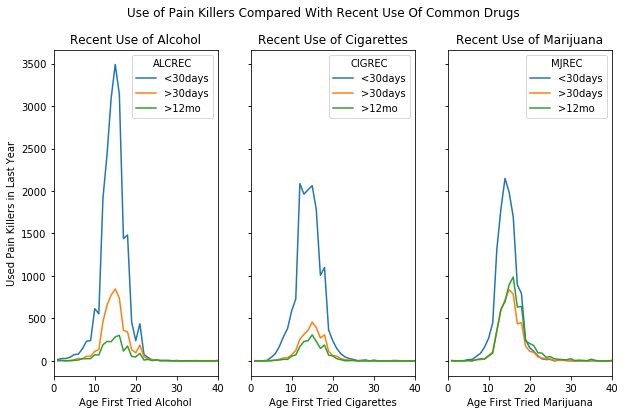

In [13]:
fig = plot2()

#### Thoughts

Given the reduction in the sample size of the data set, barring statistical measures, anecdotally it appears that if marijuana is a gateway drug for pain killers, and recency of hard drug use correlates with recency of gateway drug use, then it would follow the same trend as alcohol and cigarettes, namely that the longer one goes without the common drug, the less likely it is that they used the hard drug within the last year.  This is in opposition with the data for marijuana, suggesting that the claims that marijuana is a gateway to pain killers requires reconsideration.

In [14]:
fig.savefig('fig2.pdf')